# Homework 1: Digit classification

    1) Download data from google drive: https://drive.google.com/file/d/1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06/view?usp=sharing
    
    2) Split data in 80/20 proportion. Please note that both the train and the test
    must contain all types of digits and all speakers, so carefully split the data.
    
    3) The AudioMNIST dataset1 consists of 30000 audio recordings (9.5 hours) 
    of spoken digits (0-9) in English with 50 repetitions per digit for each of the 60 different speakers.
    
    4) Build a classificator of spoken digits. You can use any neural network architecture you like.
    
    5) Each wavfile has the following format: digit_speakerid_wavid.wav
        For example, 6_01_47.wav:
            6 -- the number 6 is spoken
            01 -- the number is spoken by speaker 1
            47 -- id of wavfile        

    Bonus:
        Use some augmentation!

In [1]:
import os
import time
import random
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The first step is to load in the data and create the train/test split. We'll augment the data by using both waveforms and mel-spectrograms.

In [2]:
# Generator for loading audio files
def load_data(path: str):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file[-4:] == '.wav':
                wav, sr = torchaudio.load(os.path.join(root, file))
                digit = file[:file.find('_')]
                speaker = file[file.find('_') + 1:file.rfind('_')]
                yield wav, digit, speaker

# Convert waveform to mel spectrogram
mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    f_min=0,
    f_max=8000,
    n_mels=80,
)

# Downsample for faster processing
downsample = torchaudio.transforms.Resample(orig_freq=1600, new_freq=800)

In [3]:
data_path = r'data\AudioMNIST'

# Load data (a la Dr. Lignos) 
data = defaultdict(lambda: defaultdict(list))
for wav, digit, speaker in load_data(data_path):
    data[speaker][digit].append((wav, int(digit)))

# Create train/test split with proportional distribuition of speakers and digits
train_data, test_data = [], []
for speakers, digit_dict in data.items():
    for digit, data in digit_dict.items():
        split = int(len(data) * 0.8)
        train_data.extend(data[:split])
        test_data.extend(data[split:])

print(f'Train size: {len(train_data)} \nTest size: {len(test_data)}')

Train size: 24000 
Test size: 6000


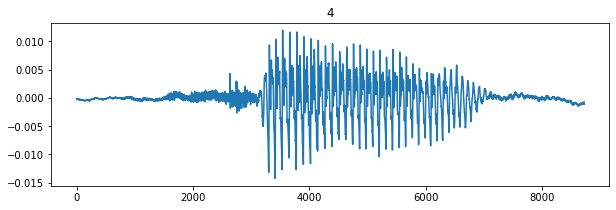

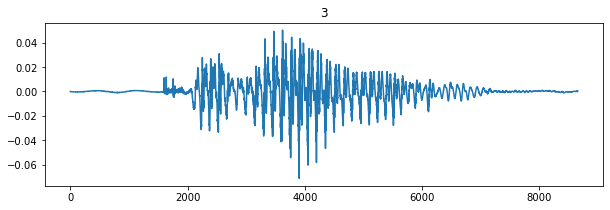

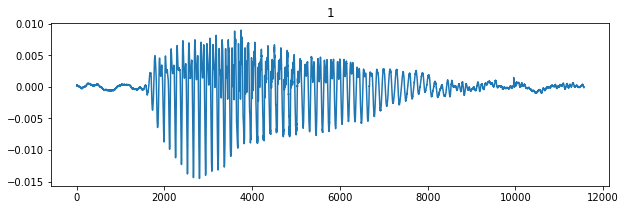

In [4]:
# Sanity check
for wav, digit in random.sample(train_data, 3):
    plt.figure(figsize=(10, 3))
    plt.plot(wav.squeeze())
    plt.title(digit)
    plt.show()

Create training batches

In [5]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):
    tensors, targets = [], []
    # Gather in lists
    for waveform, digit in batch:
        tensors += [waveform]
        targets += [torch.tensor(digit)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Next, we define a basic `pytorch` deep learning model.

In [6]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=train_data[0][0].shape[0], n_output=10)
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Numbe

Specify the optimizer.

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) 

And write the training protocol.

In [8]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [9]:
log_interval = 20
n_epoch = 10
losses = []

for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    test(model, epoch)
    scheduler.step()

Train Epoch: 1 [0/24000 (0%)]	Loss: 2.355340
Train Epoch: 1 [5120/24000 (21%)]	Loss: 0.990203
Train Epoch: 1 [10240/24000 (43%)]	Loss: 0.488673
Train Epoch: 1 [15360/24000 (64%)]	Loss: 0.335372
Train Epoch: 1 [20480/24000 (85%)]	Loss: 0.218999

Test Epoch: 1	Accuracy: 2411/6000 (40%)

Train Epoch: 2 [0/24000 (0%)]	Loss: 0.145463
Train Epoch: 2 [5120/24000 (21%)]	Loss: 0.137233
Train Epoch: 2 [10240/24000 (43%)]	Loss: 0.111953
Train Epoch: 2 [15360/24000 (64%)]	Loss: 0.074155
Train Epoch: 2 [20480/24000 (85%)]	Loss: 0.082999

Test Epoch: 2	Accuracy: 1325/6000 (22%)

Train Epoch: 3 [0/24000 (0%)]	Loss: 0.071144
Train Epoch: 3 [5120/24000 (21%)]	Loss: 0.079797
Train Epoch: 3 [10240/24000 (43%)]	Loss: 0.082862
Train Epoch: 3 [15360/24000 (64%)]	Loss: 0.049086
Train Epoch: 3 [20480/24000 (85%)]	Loss: 0.095262

Test Epoch: 3	Accuracy: 2221/6000 (37%)

Train Epoch: 4 [0/24000 (0%)]	Loss: 0.058268
Train Epoch: 4 [5120/24000 (21%)]	Loss: 0.123036
Train Epoch: 4 [10240/24000 (43%)]	Loss: 0.02907